# Данные о среднемесячных уровнях заработной платы в России

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

- Визуальный анализ ряда
- Стабилизация дисперсии (при необходимости)
- Выбор порядка дифференцирования
- Выбор начальных приближений для p, q, P, Qp,q,P,Q
- Обучение и сравнение моделей-кандидатов, выбор победителя
- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Qp,q,P,Q.
- Прогнозирование с помощью финальной модели.
- Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
# это самописная функция преобразования Бокса-Кокса, поскольку в стандартных библиотеках
# ее нет
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [51]:
# при чтении датафрейма нужно обратить внимание на правильный запрос метки времени 
wage = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month', parse_dates=True, dayfirst=True)
wage.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


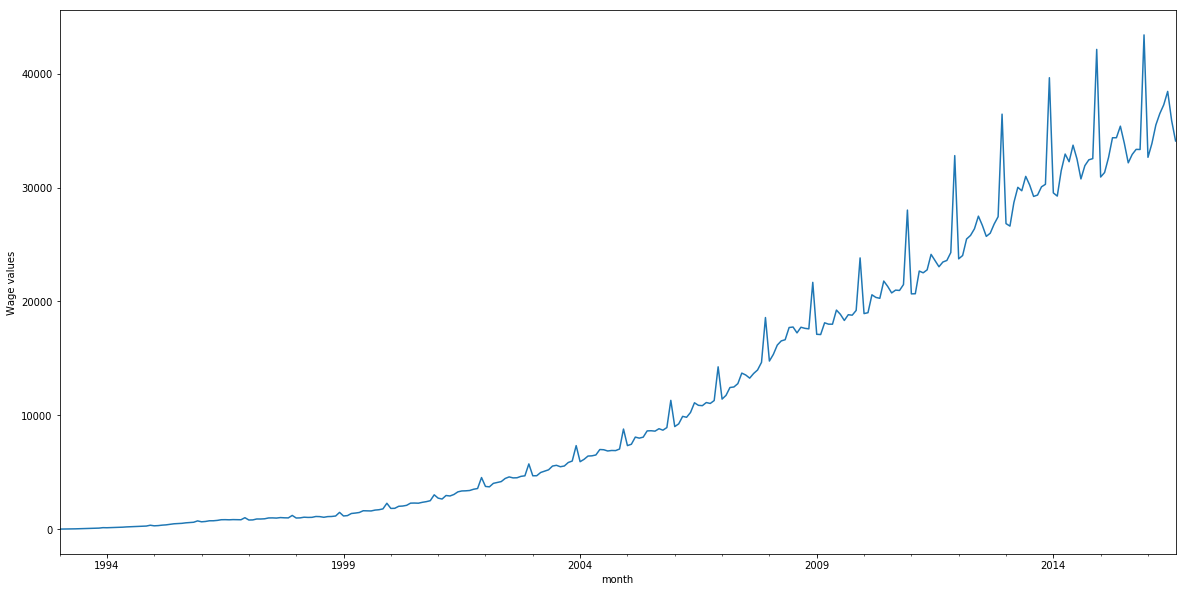

In [52]:
# смотрим в целом
plt.figure(figsize(20,10))
wage.WAG_C_M.plot()
plt.ylabel('Wage values')
pylab.show()

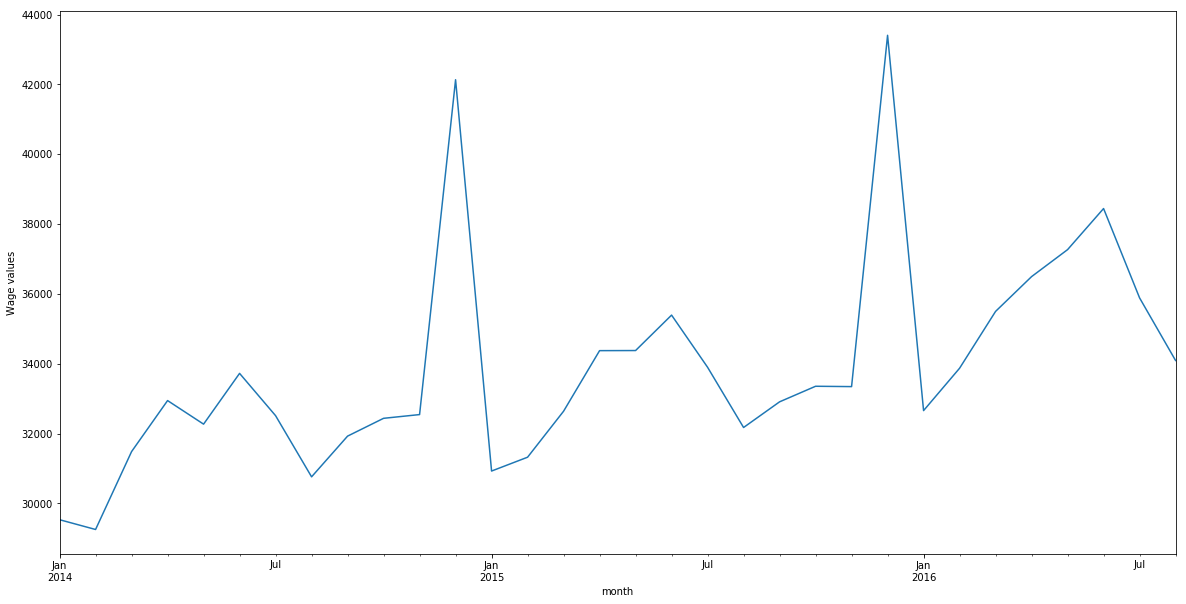

In [53]:
# смотрим укрупненно для определения наличия годового цикла
plt.figure(figsize(20,10))
wage.WAG_C_M[252:].plot()
plt.ylabel('Wage values')
pylab.show()

у ряда сильно выраженная годовая сезонность и есть нелинейный тренд. дисперсия к концу графика более сильно выражена

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

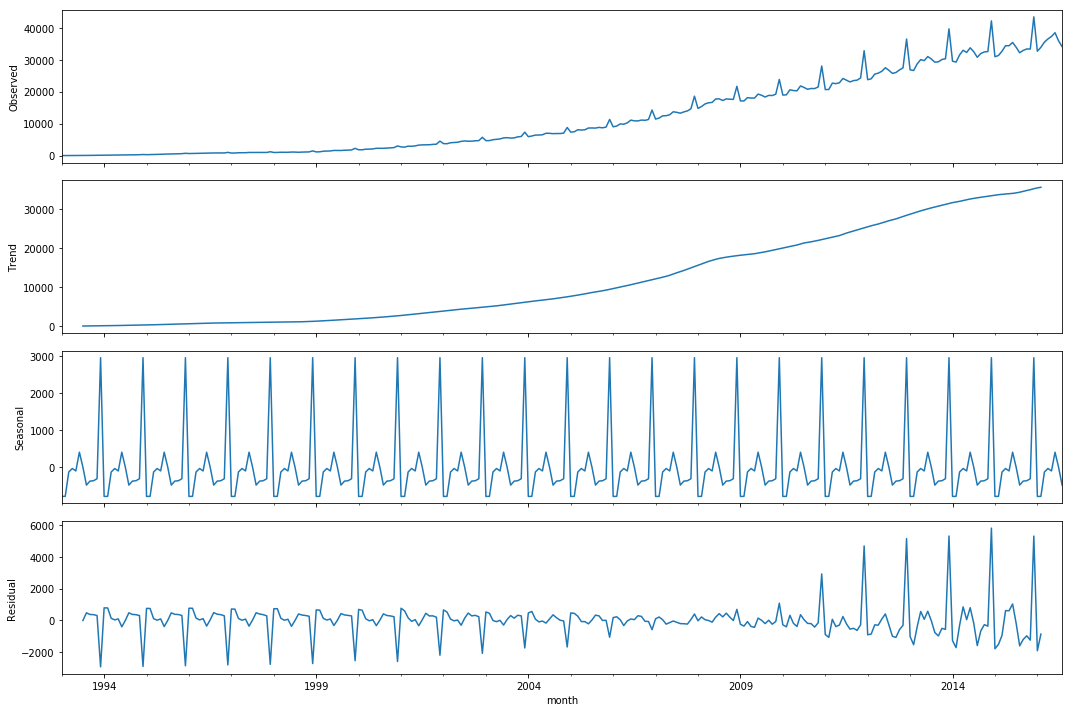

In [54]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['WAG_C_M'])[1])
# гипотеза нестационарности не отвергается, однако значение пограничное
# STL-декомпозиция это разложение, которое позволяет визуально посмотреть 
# из каких компонент состоит ряд

- Проверка критерия Дики-Фуллера говорит о явной нестационарности модели.
- Подтверждена гипотеза от тренде на повышение
- Подтверждена гипотеза о годовом цикле
- По графику шума видно, что там есть еще какая-то информация то есть "остаток" содержит структуру. </p>
<p><b>Вывод:</b> данный ряд надо стабилизировать для продолжения анализа.</p>


### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


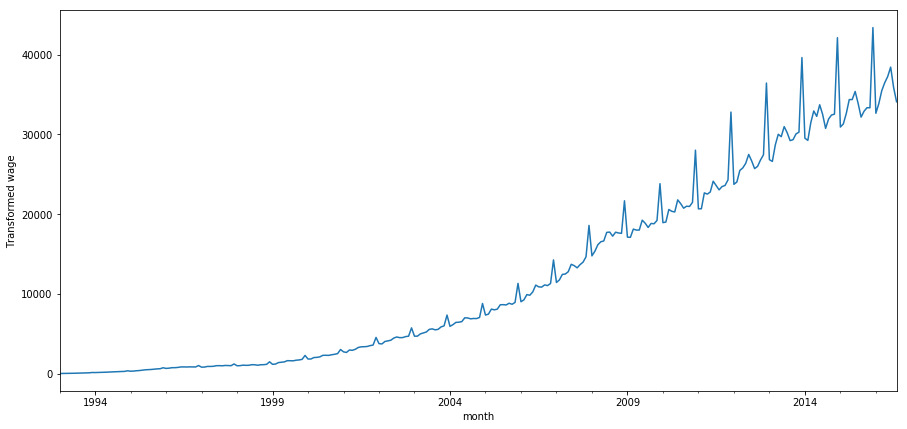

In [55]:
wage['WAG_C_M_boxcox'], lmbda = stats.boxcox(wage['WAG_C_M'])
plt.figure(figsize(15,7))
wage['WAG_C_M'].plot()
plt.ylabel(u'Transformed wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['WAG_C_M_boxcox'])[1])
# wage['WAG_C_M_boxcox'], lmbda = stats.boxcox(wage['WAG_C_M']) возвращает преобразованный ряд 
# и наилучшее лямбда
# по критерию Дики-Фуллера нулевая гипотеза о нестационарности отвергается
# тем не менее тренд виден!нужно от него избавиться обычным дифференцированием

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

In [56]:
# делаем фифференцирование чтобы добиться стационарности
wage['WAG_C_M_boxcox_diff'] = wage.WAG_C_M_boxcox - wage.WAG_C_M_boxcox.shift(12)
wage[10:14]

,WAG_C_M,WAG_C_M_boxcox,WAG_C_M_boxcox_diff
month,,,
1993-11-01,101.5,9.018525,NaN
1993-12-01,141.2,10.182060,NaN
1994-01-01,134.2,9.996196,6.005802
1994-02-01,144.7,10.272455,5.813697


Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

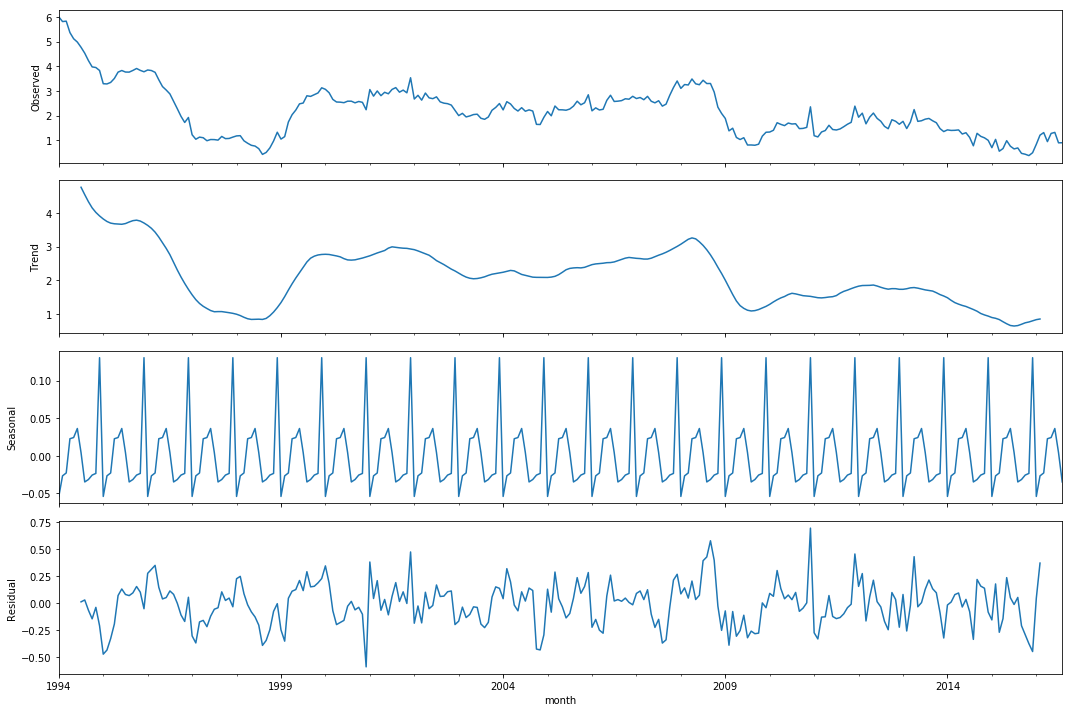

In [57]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage['WAG_C_M_boxcox_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['WAG_C_M_boxcox_diff'][12:])[1])
# после проведения сезонного дифференцирования гипотеза нестационарности не отвергается

- Критерий Дики-Фуллера не отвергает гипотезу нестационарности
- Шум потерял осмысленность
- Тренд все еще выражен. Добавим обычное дифференцирование.

In [58]:
wage['WAG_C_M_diff2'] = wage['WAG_C_M_boxcox_diff'] - wage['WAG_C_M_boxcox_diff'].shift(1)
wage[10:14]

,WAG_C_M,WAG_C_M_boxcox,WAG_C_M_boxcox_diff,WAG_C_M_diff2
month,,,,
1993-11-01,101.5,9.018525,NaN,NaN
1993-12-01,141.2,10.182060,NaN,NaN
1994-01-01,134.2,9.996196,6.005802,NaN
1994-02-01,144.7,10.272455,5.813697,-0.192106


Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

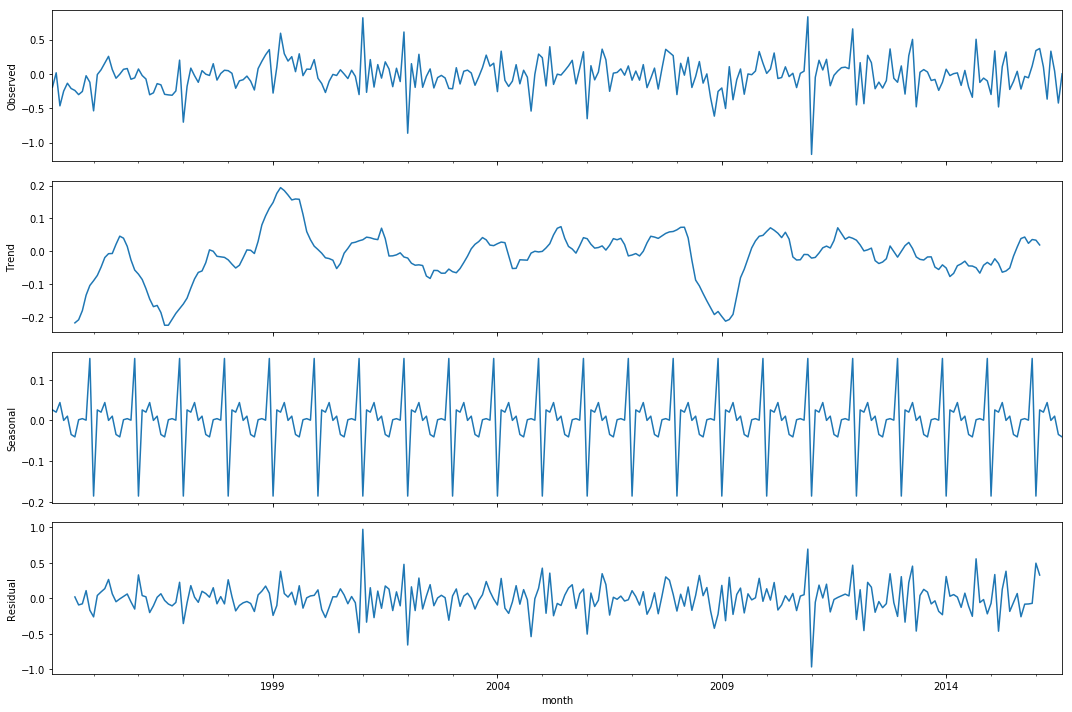

In [59]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M_diff2[13:])[1])
#  на еще раз продифференцированом ряде гипотеза нестационарности уверенно отвергается

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет: был [1,4], а сейчас стал [-0.2, 0.2].

## Подбор модели

Памятка - отсчёт лагов идёт с "0". Т.е. следующий сезонный лаг будет при лаге 12, дальше 24...
Посмотрим на ACF и PACF полученного ряда:

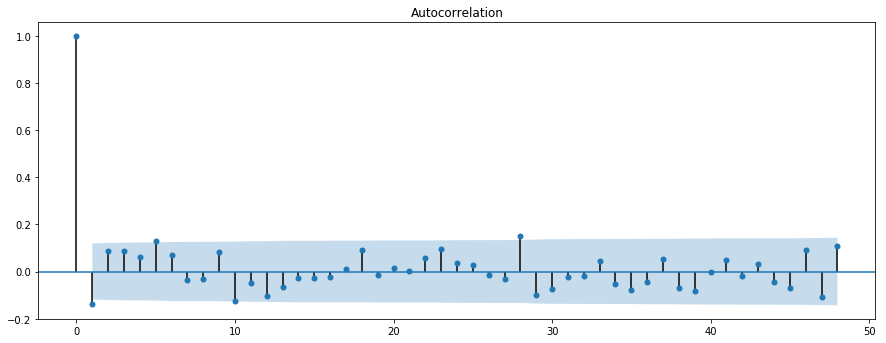

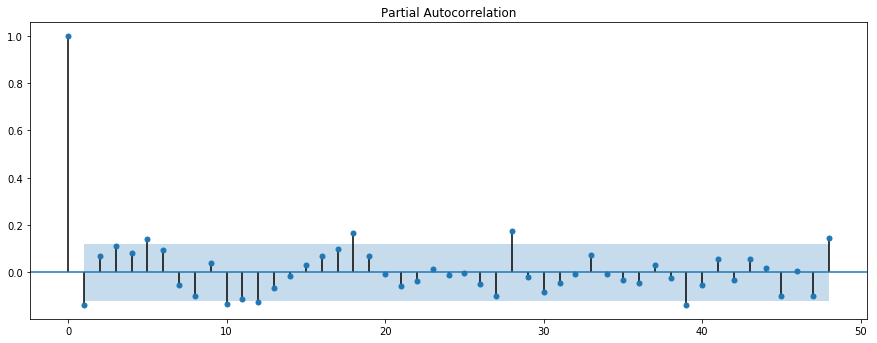

In [60]:
plt.figure(figsize(15,12))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

По верхнему графику подбираем Q, q 

Для Q смотрим сезонные лаги (12,24,36...). В автокорреляционном графике выходят из коридора значимости только два 0 и 1. Все остальные в рамках статистически незначимых значений. Берем первый . Таким образом для Q берем 0 

Что касается q то для его начального приближения нужен максимальный значимый несезонный лаг.здесь один более-менее значимый несезоннй лаг- 1. таким образом начальное приближение для q мы будем брать 1

В графике частично-автокорреляционной функции из коридора статистически незначимых значений выходят лаги со значениями: 0,1,18,28,39,48. 

Для P смотрим на значимые сезонные лаги: 0, 48. Есть ещё промежуточный (по границе коридора значимости) - 12. Выходит, что для P мы рассматриваем значения: 0, 1 (12/12) и 4 (48/12). Попробуем P=1.

Смотрим на несезонные лаги. Для несезонных лагов значимыми являются лаги - 1, 18, 28 и 39. В данном случае я возьму p=1, но я также проверяла модель и для p=39. (результаты ниже). 

Начальные приближения: Q=0, q=1, P=1, p=0

In [69]:
# делаем перебор всех значений от 0 до заданных приближений
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [70]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [71]:
%%time
results = []
best_aic = float("inf")
# отключить warnings. просто будут выводиться параметры модели, которая не сошлась  
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        # сезонная модель SARIMA настраивается здесь sm.tsa.statespace.SARIMAX()
        model=sm.tsa.statespace.SARIMAX(wage.WAG_C_M_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 13.8 s, sys: 233 ms, total: 14 s
Wall time: 4.35 s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [72]:
# смотрим на лучшие модели
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


Лучшая модель:

In [73]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     WAG_C_M_boxcox   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Tue, 24 Dec 2019   AIC                              0.341
Time:                                    18:42:33   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Её остатки:

Критерий Стьюдента: p=0.090789
Критерий Дики-Фуллера: p=0.000003


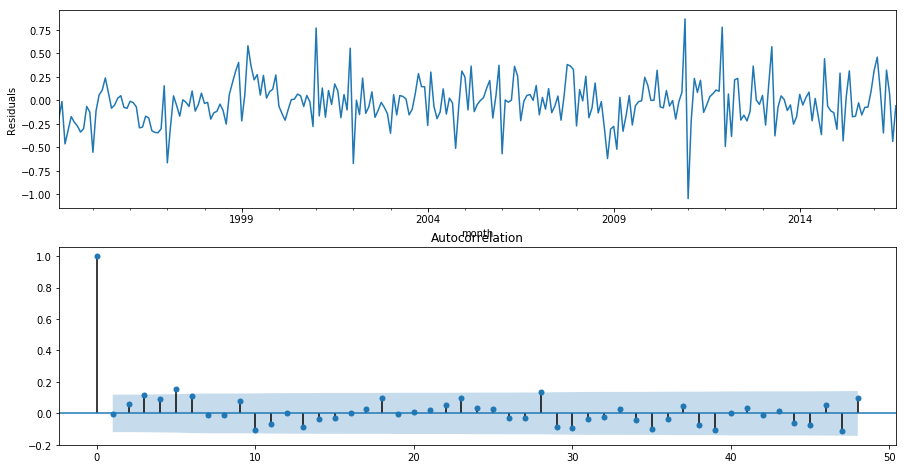

In [74]:
# визуальный анализ остатков модели
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])


Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Некоторые лаги значимо отличаются от 0 но они достаточно большие
Посмотрим, насколько хорошо модель описывает данные:

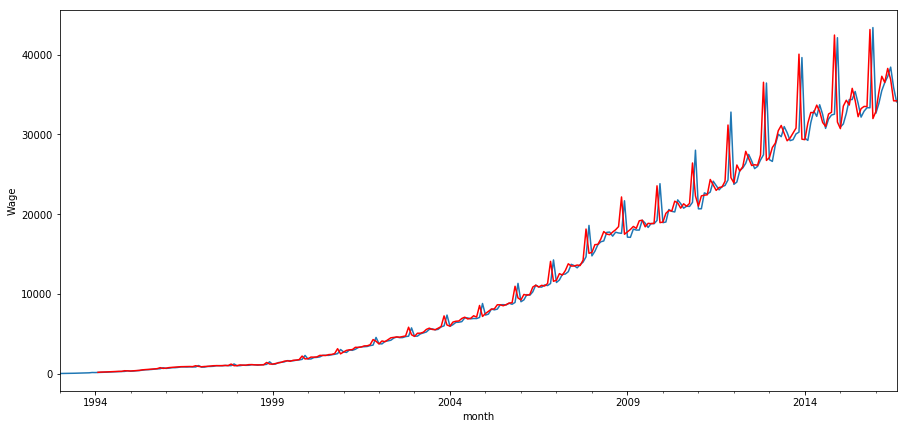

In [75]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
for i in range(wage.shape[0]):
    try:
        wage.model[i] = wage.model[i+1]
    except:
        pass
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()

наблюдаем, что восстановленная модель соответствует факту

### Прогноз

In [86]:
from datetime import datetime

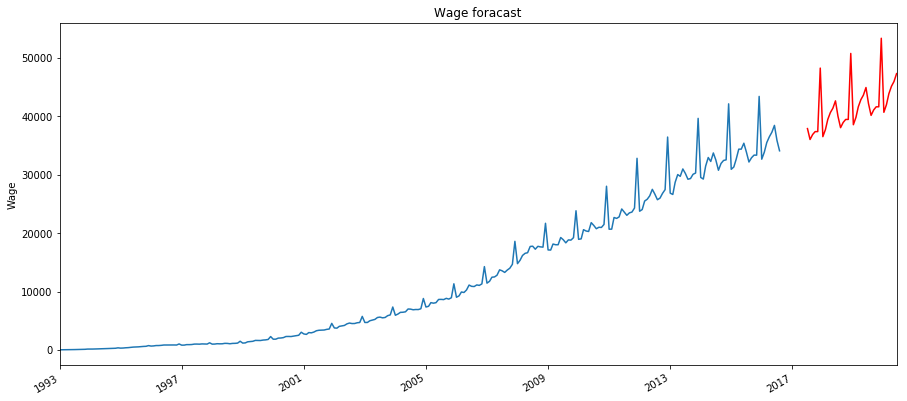

In [108]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.strptime("2017-07-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
# здесь строится прогноз. обязательно нужно применить обратное преобразование 
# к преобразованию Бокса-Кокса
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=329), lmbda)
plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Wage')
plt.title('Wage foracast')
pylab.show()

предсказание отражает тренд и рост дисперсии реальных данных

In [19]:
import statsmodels
statsmodels.__version__

'0.9.0'